In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("TCC").getOrCreate()

21/11/12 14:59:43 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.23.128 instead (on interface ens33)
21/11/12 14:59:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/12 14:59:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [839]:
data = spark.read.csv("/mnt/hgfs/shared_folder/hst_scr.csv",
                      inferSchema=True,
                     header=True,
                     )

In [840]:
data.show()

+----+---------+---------+---------------+---------------+-------------+---------+------------------+----------+
| ano|id_regiao|perc_inad|taxa_desemprego|renda_percapita|qtd_populacao|valor_pib|taxa_alfabetizacao|taxa_selic|
+----+---------+---------+---------------+---------------+-------------+---------+------------------+----------+
|2020|        1|1.9210129|           11.0|           1536|     18094551|    35506|              90.3|       1.9|
|2020|        2|3.2706366|      16.333334|            913|     57374243|    46781|              82.9|       1.9|
|2020|        3|2.6512673|      13.333333|            949|     17082343|    12982|              88.3|       1.9|
|2020|        4| 2.574358|           14.5|           1549|     89012240|   151193|              94.5|       1.9|
|2020|        5| 1.810782|      7.3333335|           1633|     30192315|   287597|              95.4|       1.9|
|2019|        1|2.5289876|            8.6|           1593|     17869940|    34820|              

In [841]:
data.printSchema()

root
 |-- ano: integer (nullable = true)
 |-- id_regiao: integer (nullable = true)
 |-- perc_inad: double (nullable = true)
 |-- taxa_desemprego: double (nullable = true)
 |-- renda_percapita: integer (nullable = true)
 |-- qtd_populacao: integer (nullable = true)
 |-- valor_pib: integer (nullable = true)
 |-- taxa_alfabetizacao: double (nullable = true)
 |-- taxa_selic: double (nullable = true)



In [842]:
data.columns

['ano',
 'id_regiao',
 'perc_inad',
 'taxa_desemprego',
 'renda_percapita',
 'qtd_populacao',
 'valor_pib',
 'taxa_alfabetizacao',
 'taxa_selic']

In [843]:
from pyspark.sql.functions import corr

In [947]:
data.select(corr("perc_inad","ano")).show()

+--------------------+
|corr(perc_inad, ano)|
+--------------------+
|-0.48865372494527193|
+--------------------+



In [845]:
data.select(corr("perc_inad","taxa_desemprego")).show()

+--------------------------------+
|corr(perc_inad, taxa_desemprego)|
+--------------------------------+
|             0.19068456362730002|
+--------------------------------+



In [846]:
data.select(corr("perc_inad","renda_percapita")).show()

+--------------------------------+
|corr(perc_inad, renda_percapita)|
+--------------------------------+
|             -0.8134400041971085|
+--------------------------------+



In [847]:
data.select(corr("perc_inad","taxa_alfabetizacao")).show()

+-----------------------------------+
|corr(perc_inad, taxa_alfabetizacao)|
+-----------------------------------+
|                 -0.661214428825589|
+-----------------------------------+



In [848]:
data.select(corr("perc_inad","taxa_selic")).show()

+---------------------------+
|corr(perc_inad, taxa_selic)|
+---------------------------+
|        0.34462666351041954|
+---------------------------+



In [849]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [884]:
assembler = VectorAssembler(inputCols=['ano',
 'id_regiao',
 'taxa_desemprego',
 'renda_percapita',
 'qtd_populacao',
 'valor_pib',
 'taxa_alfabetizacao',
 'taxa_selic'],
                            outputCol='features')

In [885]:
output = assembler.transform(data)

In [886]:
output.printSchema()

root
 |-- ano: integer (nullable = true)
 |-- id_regiao: integer (nullable = true)
 |-- perc_inad: double (nullable = true)
 |-- taxa_desemprego: double (nullable = true)
 |-- renda_percapita: integer (nullable = true)
 |-- qtd_populacao: integer (nullable = true)
 |-- valor_pib: integer (nullable = true)
 |-- taxa_alfabetizacao: double (nullable = true)
 |-- taxa_selic: double (nullable = true)
 |-- features: vector (nullable = true)



In [887]:
output.count()

45

In [888]:
output.head(1)

[Row(ano=2020, id_regiao=1, perc_inad=1.9210129, taxa_desemprego=11.0, renda_percapita=1536, qtd_populacao=18094551, valor_pib=35506, taxa_alfabetizacao=90.3, taxa_selic=1.9, features=DenseVector([2020.0, 1.0, 11.0, 1536.0, 18094551.0, 35506.0, 90.3, 1.9]))]

In [889]:
final_data = output.select("features","perc_inad")

In [890]:
final_data.show()

+--------------------+---------+
|            features|perc_inad|
+--------------------+---------+
|[2020.0,1.0,11.0,...|1.9210129|
|[2020.0,2.0,16.33...|3.2706366|
|[2020.0,3.0,13.33...|2.6512673|
|[2020.0,4.0,14.5,...| 2.574358|
|[2020.0,5.0,7.333...| 1.810782|
|[2019.0,1.0,8.6,1...|2.5289876|
|[2019.0,2.0,12.88...| 3.904583|
|[2019.0,3.0,11.83...|3.3900259|
|[2019.0,4.0,10.75...|3.2406075|
|[2019.0,5.0,6.333...|2.3858519|
|[2018.0,1.0,8.6,1...|2.3688977|
|[2018.0,2.0,13.55...|3.5395253|
|[2018.0,3.0,13.16...|3.4302285|
|[2018.0,4.0,11.25...|3.0524065|
|[2018.0,5.0,6.666...|2.1732743|
|[2017.0,1.0,9.2,1...|2.7350109|
|[2017.0,2.0,13.11...|3.7792401|
|[2017.0,3.0,11.5,...|3.8094902|
|[2017.0,4.0,12.0,...| 3.316889|
|[2017.0,5.0,7.333...|2.3125508|
+--------------------+---------+
only showing top 20 rows



In [891]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [894]:
from pyspark.ml.regression import LinearRegression

In [895]:
lr = LinearRegression(labelCol = "perc_inad")

In [922]:
lr_model = lr.fit(test_data)

21/11/18 16:52:13 WARN Instrumentation: [995bc204] regParam is zero, which might cause numerical instability and overfitting.


In [923]:
test_results = lr_model.evaluate(test_data)

In [924]:
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|  0.1246438421491729|
|-0.05100224407969911|
| 0.06979424847390359|
| -0.1018085103879427|
| -0.2268535148579005|
|-0.02831404645337...|
| 0.24881551321226913|
|-0.02392376560619791|
|-0.02306441167264...|
|0.019010102648128857|
| 0.20975588776721654|
| -0.0380500941871591|
|  -0.229920578954248|
|-0.11509578683733768|
| 0.08432276779520853|
|-0.04156591519496...|
| 0.12325650618542405|
+--------------------+



In [925]:
test_results.rootMeanSquaredError

0.12938739405261135

In [926]:
test_results.r2

0.9770326693083012

In [927]:
lr_model = lr.fit(train_data)

21/11/18 16:53:48 WARN Instrumentation: [6b935931] regParam is zero, which might cause numerical instability and overfitting.


In [928]:
train_results = lr_model.evaluate(train_data)

In [929]:
train_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|  0.3422431268360455|
| 0.36949100802203816|
|-0.11557309549911032|
|-0.19877857035532198|
| 0.04921023840620453|
| -0.3644731766914324|
|-0.23261421637661472|
| -0.3201481353950153|
|0.029020810082103665|
|-0.25000742120005803|
|  0.2818885641505475|
| 0.22591320233934553|
| 0.10288104912800566|
|   -0.13383985976875|
|-0.12521114338335426|
|0.025702790417567734|
| 0.12906195263847398|
|-0.02107478636531...|
|  0.1108300816220642|
| -0.0660716150384042|
+--------------------+
only showing top 20 rows



In [930]:
train_results.rootMeanSquaredError

0.2639292456248446

In [931]:
train_results.r2

0.8722061355604154

In [932]:
unlabeled_data = output.select("features")

In [933]:
unlabeled_data.show()

+--------------------+
|            features|
+--------------------+
|[2020.0,1.0,11.0,...|
|[2020.0,2.0,16.33...|
|[2020.0,3.0,13.33...|
|[2020.0,4.0,14.5,...|
|[2020.0,5.0,7.333...|
|[2019.0,1.0,8.6,1...|
|[2019.0,2.0,12.88...|
|[2019.0,3.0,11.83...|
|[2019.0,4.0,10.75...|
|[2019.0,5.0,6.333...|
|[2018.0,1.0,8.6,1...|
|[2018.0,2.0,13.55...|
|[2018.0,3.0,13.16...|
|[2018.0,4.0,11.25...|
|[2018.0,5.0,6.666...|
|[2017.0,1.0,9.2,1...|
|[2017.0,2.0,13.11...|
|[2017.0,3.0,11.5,...|
|[2017.0,4.0,12.0,...|
|[2017.0,5.0,7.333...|
+--------------------+
only showing top 20 rows



In [934]:
predictions = lr_model.transform(unlabeled_data)

In [935]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[2020.0,1.0,11.0,...|2.0128887710887966|
|[2020.0,2.0,16.33...|3.4765766677696774|
|[2020.0,3.0,13.33...| 3.193046433748009|
|[2020.0,4.0,14.5,...|3.1733547223744836|
|[2020.0,5.0,7.333...|  1.40385273395259|
|[2019.0,1.0,8.6,1...|2.0009812198351256|
|[2019.0,2.0,12.88...| 3.206398542558759|
|[2019.0,3.0,11.83...|3.2609410406894312|
|[2019.0,4.0,10.75...|3.0035846425523687|
|[2019.0,5.0,6.333...| 1.717201254711199|
|[2018.0,1.0,8.6,1...| 2.258067618377936|
|[2018.0,2.0,13.55...|3.6055969150384044|
|[2018.0,3.0,13.16...| 3.838900532471712|
|[2018.0,4.0,11.25...|3.3780437808194392|
|[2018.0,5.0,6.666...|1.9107849243426926|
|[2017.0,1.0,9.2,1...| 2.605948947361526|
|[2017.0,2.0,13.11...|3.8700294673438975|
|[2017.0,3.0,11.5,...|3.7671369609971634|
|[2017.0,4.0,12.0,...|3.8187352499329563|
|[2017.0,5.0,7.333...| 2.333625586365315|
+--------------------+------------

In [936]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [937]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

In [938]:
def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

In [941]:
resultado_final = predictions.withColumn("coluna",to_array(col("features"))).select([col("coluna")[i] for i in range(2)]+["prediction"])

In [942]:
resultado_final.show()

+---------+---------+------------------+
|coluna[0]|coluna[1]|        prediction|
+---------+---------+------------------+
|   2020.0|      1.0|2.0128887710887966|
|   2020.0|      2.0|3.4765766677696774|
|   2020.0|      3.0| 3.193046433748009|
|   2020.0|      4.0|3.1733547223744836|
|   2020.0|      5.0|  1.40385273395259|
|   2019.0|      1.0|2.0009812198351256|
|   2019.0|      2.0| 3.206398542558759|
|   2019.0|      3.0|3.2609410406894312|
|   2019.0|      4.0|3.0035846425523687|
|   2019.0|      5.0| 1.717201254711199|
|   2018.0|      1.0| 2.258067618377936|
|   2018.0|      2.0|3.6055969150384044|
|   2018.0|      3.0| 3.838900532471712|
|   2018.0|      4.0|3.3780437808194392|
|   2018.0|      5.0|1.9107849243426926|
|   2017.0|      1.0| 2.605948947361526|
|   2017.0|      2.0|3.8700294673438975|
|   2017.0|      3.0|3.7671369609971634|
|   2017.0|      4.0|3.8187352499329563|
|   2017.0|      5.0| 2.333625586365315|
+---------+---------+------------------+
only showing top

In [943]:
arquivo_final = resultado_final.select("coluna[0]","coluna[1]","prediction")

In [944]:
arquivo_final

DataFrame[coluna[0]: double, coluna[1]: double, prediction: double]

In [945]:
arquivo_final.write.mode("overwrite").format("csv").save("/mnt/hgfs/shared_folder/resultado")


In [953]:
grafico = spark.read.csv("/mnt/hgfs/shared_folder/resultado/resultado_grafico.csv",
                      inferSchema=True,
                     header=True,
                     )

In [954]:
grafico.show()

+----+-------+
| scr|predict|
+----+-------+
|3.61|   3.32|
|5.01|   4.66|
| 4.7|   4.36|
|4.31|   3.94|
|3.17|   3.28|
|2.75|   2.95|
|4.28|   4.23|
|4.47|   4.06|
| 3.5|   3.68|
|2.49|   2.85|
|2.54|   2.77|
|3.73|   4.05|
|3.78|   3.75|
|3.21|   3.46|
|2.23|   2.45|
|3.14|   2.86|
|4.42|   4.09|
|4.24|   4.01|
|3.74|   3.87|
|2.75|   2.65|
+----+-------+
only showing top 20 rows



In [957]:
x_ax = range(0, grafico.count())
y_pred = grafico.select("predict").collect()
y_orig = grafico.select("scr").collect() 

In [958]:
import matplotlib.pyplot as plt

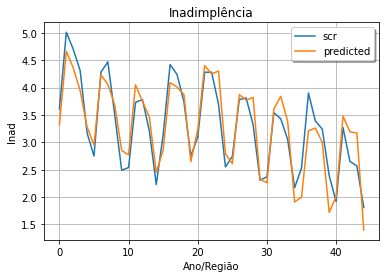

In [963]:
plt.plot(x_ax, y_orig, label="scr")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Inadimplência")
plt.xlabel('Ano/Região')
plt.ylabel('Inad')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()